In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout, Bidirectional 
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [13]:
data_train = pd.read_csv('data.csv',parse_dates=['Date'])
data_train.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [3]:
data_train.tail()

,Date,Open,High,Low,Close,Volume,Name
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
3018,2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


Text(0.5, 1.0, 'AABA High Value')

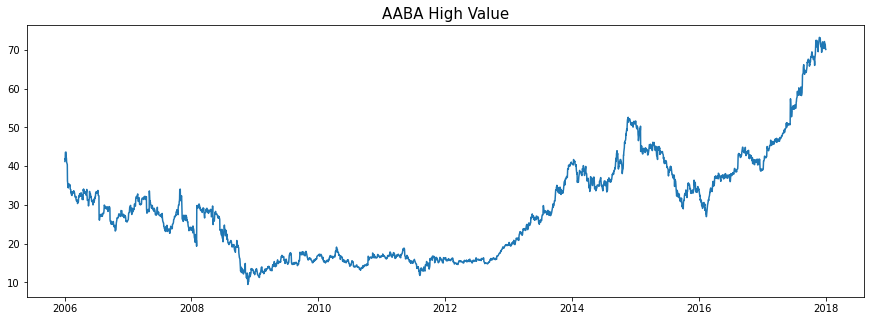

In [4]:
dates = data_train['Date'].values
high = data_train['High'].values

plt.figure(figsize=(15,5))
plt.plot(dates, high)
plt.title('AABA High Value',fontsize=15)

In [5]:
print("MAE harus di bawah "+str(data_train['Open'].max()-data_train['Open'].min()))

MAE harus di bawah 63.919999999999995


In [6]:
def windowed_dataset(series, shuffle_buffer, window_size = 40, batch_size = 100):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(dates, high, test_size=0.2, shuffle=False)

train_set = windowed_dataset(Y_train, shuffle_buffer=1000)
val_set = windowed_dataset( Y_test, shuffle_buffer=1000)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(120, activation="relu"),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<10) and (logs.get('val_mae')<10):
      print('\nMAE kurang dari <10%!')
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [11]:
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - 20s 363ms/step - loss: 23.7382 - mae: 24.2382 - val_loss: 44.7657 - val_mae: 45.2657
Epoch 2/100
24/24 [==============================] - 5s 211ms/step - loss: 21.8013 - mae: 22.3013 - val_loss: 39.4757 - val_mae: 39.9757
Epoch 3/100
24/24 [==============================] - 3s 112ms/step - loss: 9.2010 - mae: 9.6917 - val_loss: 17.2433 - val_mae: 17.7409
Epoch 4/100
24/24 [==============================] - 3s 108ms/step - loss: 7.5268 - mae: 8.0084 - val_loss: 15.2673 - val_mae: 15.7604
Epoch 5/100
24/24 [==============================] - ETA: 0s - loss: 4.2010 - mae: 4.6709
MAE kurang dari <10%!
24/24 [==============================] - 3s 105ms/step - loss: 4.2010 - mae: 4.6709 - val_loss: 5.5117 - val_mae: 5.9652
